In [14]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
#     plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "Q"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [15]:
data_codes = {"Total Debt":"TODNS",
              "Federal Debt": "FGSDODNS",
              "State and Local Debt":"SLGSDODNS",
              "Commercial and Industrial Loans":"TOTCI",
              "Total Loans, Excluding Federal Government":"ASTLL",
              "Nominal GDP":"GDP",
              "Real GDP":"GDPC1",
              "G":"GCE",
              "I":"GPDI",
              "C":"PCEC",
              "NX":"NETEXP",
              "Expected Inflation: 5 Year Breakeven Rate":"T5YIE",
              "CPI: Urban Consumption":"CPIAUCSL",
              "Federal Funds Rate": "DFF",
              "Balance Sheet: Total Assets": "WALCL",
              "Currency in Circulation": "WCURCIR",
              "Unemployment Rate": "UNRATE",
              "Aaa Rate":"AAA",
              "2 Year Treasury Rate": "DGS2",
              "5 Year Treasury Rate": "DGS5",
              "10 Year Treasury Rate": "DGS10",
              "30 Year Treasury Rate": "DGS20"}


start = datetime.datetime(1950, 1, 1)
end =datetime.datetime.today()

annual_div = {"Q":4,
             "W":52,
             "M":12}
# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
if "data_gathered" not in locals():
    freq = "M"
    year = annual_div[freq]
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    #data.fillna(0, inplace=True)
    data["Currency in Circulation"] = data["Currency in Circulation"].mul(1000)
#     for key in data.keys():
#         data[key + " % change"] = data[key].pct_change(year) * 100
#         data["Log " + key]= np.log(data[key])
    data["Currency in Circulation / Total Assets"] = data["Currency in Circulation"].div(data["Balance Sheet: Total Assets"])
    data["Total Debt"] =data["Total Debt"].mul(1000) 
    data["Federal Debt"] =data["Federal Debt"].mul(1000) 
    data["State and Local Debt"] =data["State and Local Debt"].mul(1000)
    data["Nominal GDP"]=data["Nominal GDP"].mul(1000)
    data["Public Debt"] = data["Federal Debt"].add(data["State and Local Debt"])
    data["Private Debt"] = data["Total Debt"].sub(data["Public Debt"])    
    data["Public Debt / GDP"] = data["Public Debt"].div(data["Nominal GDP"]).mul(100)
    data["Private Debt / GDP"] = data["Private Debt"].div(data["Nominal GDP"]).mul(100)
    data["Public Debt / Private Debt"] = data["Public Debt"].div(data["Private Debt"]).mul(100)
    data["Public Debt / Total Debt"] = data["Public Debt"].div(data["Total Debt"]).mul(100)
    data["Aaa and 10 Year Treasury Rate Spread"] = data["Aaa Rate"].sub(data["10 Year Treasury Rate"]) 
    data["AAA - FFR"] = data["Aaa Rate"].sub(data["Federal Funds Rate"]) 

    data["Year"] = data.index
    data["Year"] = data["Year"].astype(str).str[:4].astype(int)
        
    # Create new variables


    data_gathered = True


In [16]:
pct_change_df = data.pct_change(4).mul(100)
pct_change_diff_df=pct_change_df.diff(4).mul(100)

In [23]:
rates = ["2 Years", "5 Years", "10 Years", "30 Years"]
filename = "https://home.treasury.gov/system/files/226/hqm_qh_pars.xls"
corporate_rates = pd.read_excel(filename, 
                     header = [4])
corporate_rates = corporate_rates.iloc[1:].rename(columns = {"Unnamed: 0":"Date"})
corporate_rates["Date"] = pd.to_datetime(corporate_rates["Date"])
corporate_rates = corporate_rates.set_index("Date").resample(freq).mean()    
corporate_rates = corporate_rates[rates]
corporate_rates

,2 Years,5 Years,10 Years,30 Years
Date,,,,
1984-01-31,11.36,11.98,12.58,11.57
1984-02-29,11.40,12.15,12.52,11.99
1984-03-31,11.87,12.51,12.91,12.39
1984-04-30,12.16,12.85,13.08,12.56
1984-05-31,12.83,13.57,13.58,13.15
...,...,...,...,...
2023-06-30,5.36,4.98,5.19,5.21
2023-07-31,5.47,5.07,5.26,5.20
2023-08-31,5.55,5.23,5.46,5.49


In [24]:
import plotly.express as px
plot_df = corporate_rates.loc["2022":,rates ]

fig = px.line(plot_df, x = plot_df.index, y = plot_df.keys(), labels = {"variable":"Maturity",
                                                                       "value" : "Interest Rate"})
fig.show()
fig.write_html("AAAYieldCurve.html")

In [31]:
for key in corporate_rates:
    data[key[:-1] + " AAA Rate"] = corporate_rates[key]
    
AAA_rates = [rate[:-1] + " AAA Rate" for rate in rates]
UST_rates = [rate[:-1] + " Treasury Rate" for rate in rates]

In [29]:
rates

['2 Years', '5 Years', '10 Years', '30 Years']

In [32]:
rate_data = data[UST_rates + AAA_rates + ["Federal Funds Rate"]]
rate_diffs = [rate + " Rate Diff" for rate in rates]
for i in range(len(rates)):
    rate = rates[i]
    AAA_rate = AAA_rates[i]
    UST_rate = UST_rates[i]
    rate_diff = rate_diffs[i]
    rate_data[rate] = rate_data[AAA_rate].sub(rate_data[UST_rate])
rate_data.dropna(inplace= True)
delta_rate_data = rate_data.diff(12)
rate_data["Year"] = rate_data.index
delta_rate_data["Year"] = delta_rate_data.index

C:\Users\JLCat\AppData\Local\Temp\ipykernel_40740\2882655445.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JLCat\AppData\Local\Temp\ipykernel_40740\2882655445.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JLCat\AppData\Local\Temp\ipykernel_40740\2882655445.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

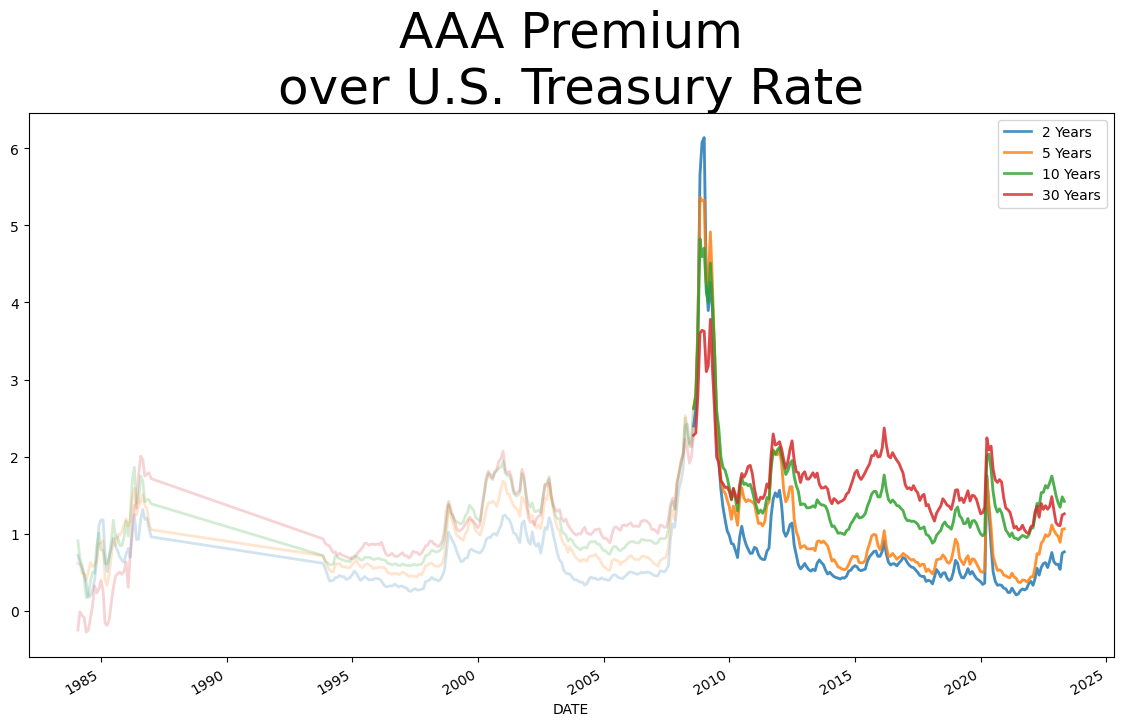

C:\Users\JLCat\AppData\Local\Temp\ipykernel_40740\4262740144.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



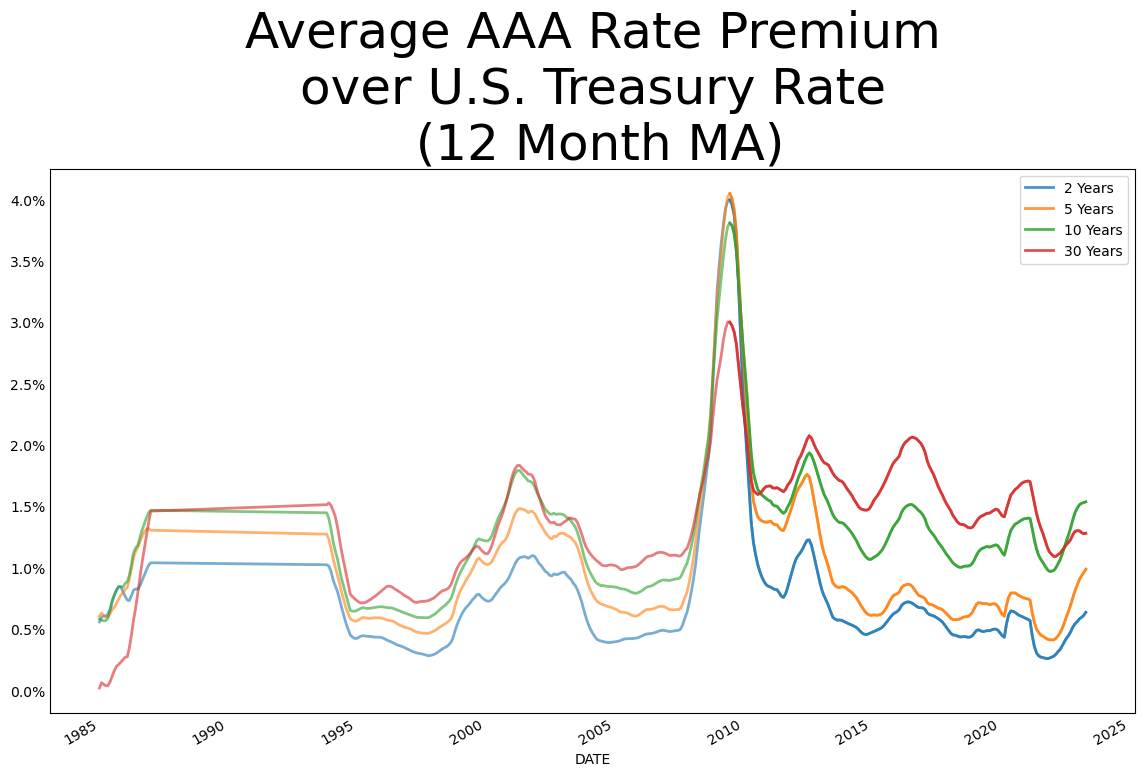

In [33]:

# for key in delta_rate_data:
#     if key != "Federal Funds Rate":
#         fig, ax = plt.subplots(figsize = (14,8))
#         rate_data.loc["2008-07-31":"2020"].plot.scatter(x = "Federal Funds Rate", 
#                                                         y = key, 
#                                                         c = "Year",
#                                                         cmap = "viridis",
#                                                         ax = ax)
#         rate_data.loc["2000":"2008-07-31"].plot.scatter(x = "Federal Funds Rate", 
#                                                         y = key, 
#                                                         ax = ax,
#                                                         c = "k", 
#                                                         alpha = .2)
#         pp.savefig(fig, bbox_inches = "tight")
#         plt.show()
#         plt.close()

fig, ax = plt.subplots(figsize = (14,8))
dates =list(rate_data.index)
num_dates = len(dates)
rate_data.loc[:, rates].plot.line(ax = ax, alpha = .2, linewidth = 2, legend = False)
rate_data.loc["2008-07-31":, rates].plot.line(ax = ax, 
                                                   alpha = .8,
                                                   color = ["C" + str(i) for i in range(5)], 
                                                   linewidth = 2,
                                                   label = [diff.replace(" Diff","") for diff in rate_diffs ])
ax.set_title("AAA Premium\nover U.S. Treasury Rate", fontsize = 36)

# pp.savefig(fig, bbox_inches = "tight")
plt.show()
plt.close()


fig, ax = plt.subplots(figsize = (14,8))
dates =list(rate_data.index)
num_dates = len(dates)
rate_data.loc[:, rates].rolling(12).mean().dropna().plot.line(ax = ax, alpha = .6, linewidth = 2, legend = False)
rate_data.loc["2008-07-31":, rates].rolling(12).mean().dropna().plot.line(ax = ax, 
                                                   alpha = .8,
                                                   color = ["C" + str(i) for i in range(5)], 
                                                   linewidth = 2,
                                                   label = [diff.replace(" Diff","") for diff in rate_diffs ])


ax.set_title("Average AAA Rate Premium\nover U.S. Treasury Rate\n (12 Month MA)", fontsize = 36)
ax.set_yticklabels(str(label) + "%" for label in ax.get_yticks())
ax.tick_params(axis=u'both', which=u'both',length=0)
# pp.savefig(fig, bbox_inches = "tight")
plt.show()
plt.close()

# pp.close()

C:\Users\JLCat\AppData\Local\Temp\ipykernel_40740\283836033.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



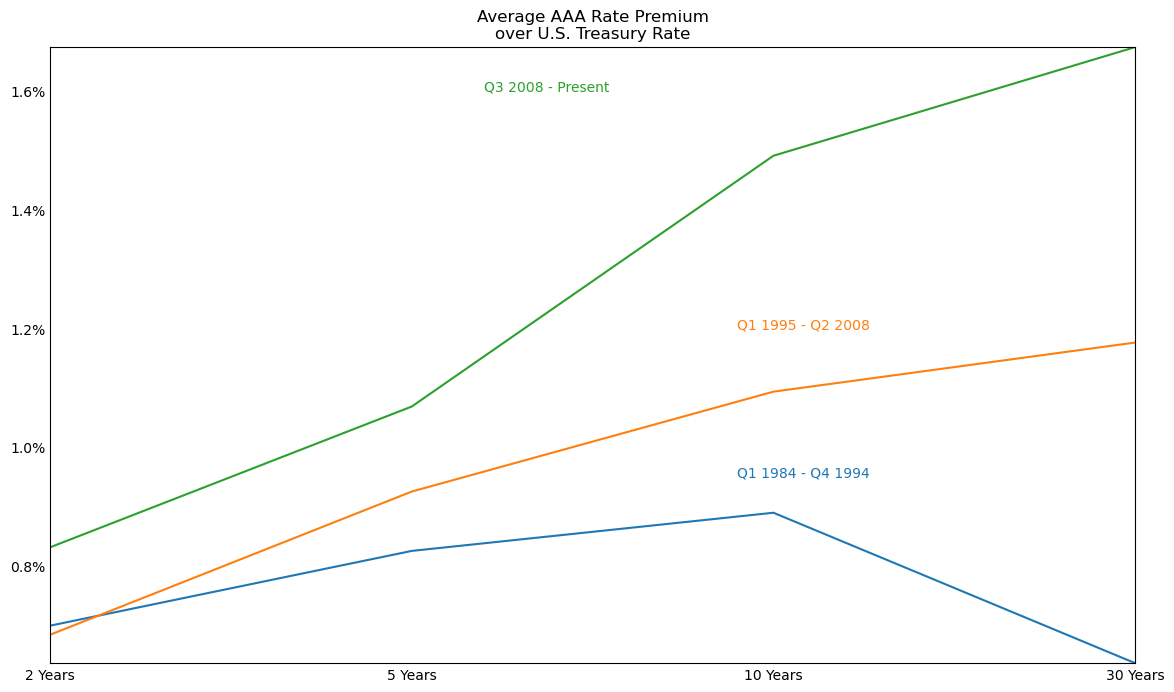

In [34]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

fig, ax = plt.subplots(figsize = (14,8))
label1 = "Q1 1984 - Q4 1994"
label2 = "Q1 1995 - Q2 2008"
label3 = "Q3 2008 - Present"
rate_data.loc[:"1994-10-31", rates].mean().plot(ax = ax, label = label1)
rate_data.loc["1995-01-31":"2008-07-31", rates].mean().plot(ax = ax, label = label2)
rate_data.loc["2008-10-31":, rates].mean().plot(ax = ax, label = label3)
ax.text(1.9, .95, label1, color = "C0")
ax.text(1.9, 1.2, label2, color = "C1")
ax.text(1.2, 1.6, label3, color = "C2")

plt.title("Average AAA Rate Premium\nover U.S. Treasury Rate")
ax.set_yticklabels(str(round(label, 1)) + "%" for label in ax.get_yticks())
ax.tick_params(axis=u'both', which=u'both',length=0)


In [35]:
rate_data.loc[:"1994-10-31", rates].mean()

2 Years     0.699161
5 Years     0.825235
10 Years    0.889580
30 Years    0.635999
dtype: float64

In [36]:
rate_data.loc["1995-01-31":"2008-07-31", rates].mean()

2 Years     0.683879
5 Years     0.925312
10 Years    1.093734
30 Years    1.176534
dtype: float64

In [37]:
rate_data.loc["2008-10-31":, rates].mean()

2 Years     0.831278
5 Years     1.068689
10 Years    1.491492
30 Years    1.674595
dtype: float64

C:\Users\JLCat\AppData\Local\Temp\ipykernel_40740\2474687915.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



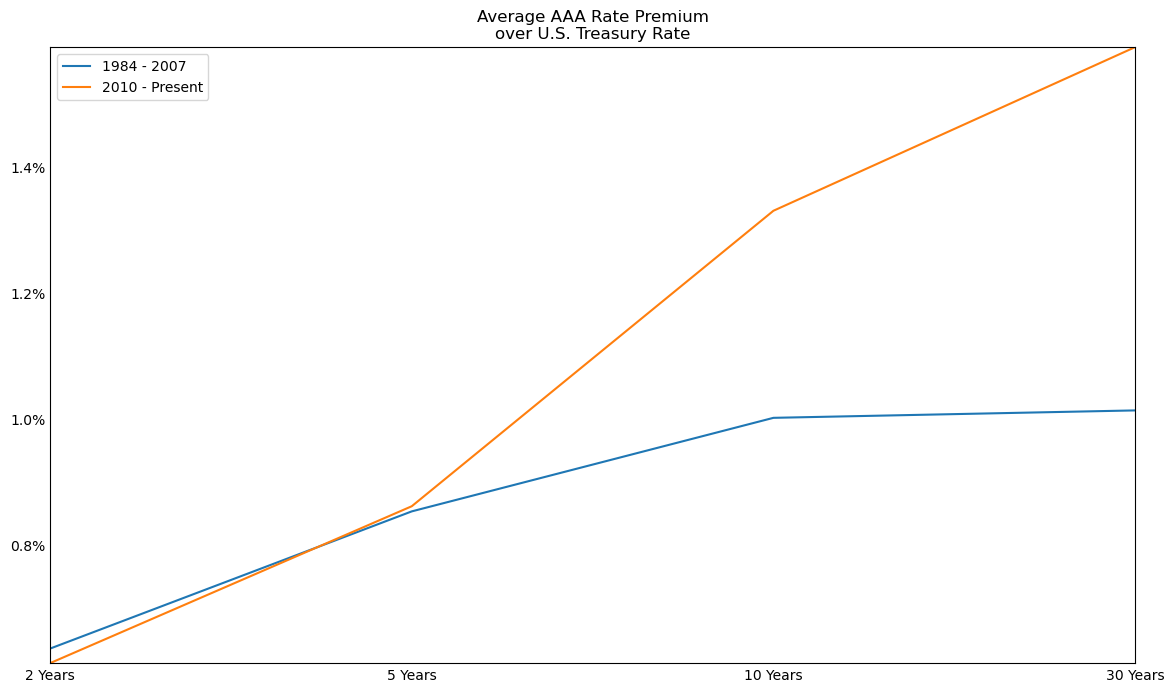

In [38]:
fig, ax = plt.subplots(figsize = (14,8))
rate_data.loc[:"2007", rates].mean().plot(ax = ax, label = "1984 - 2007")
rate_data.loc["2010":, rates].mean().plot(ax = ax, label = "2010 - Present")
plt.legend()
plt.title("Average AAA Rate Premium\nover U.S. Treasury Rate")
ax.set_yticklabels(str(round(label, 1)) + "%" for label in ax.get_yticks())
ax.tick_params(axis=u'both', which=u'both',length=0)


In [41]:
for i in [2,5,10, 30]:
    data[str(i) + " Year Premium"] = rate_data[str(i) + " Years"]

<AxesSubplot:xlabel='Private Debt / GDP', ylabel='30 Year Premium'>

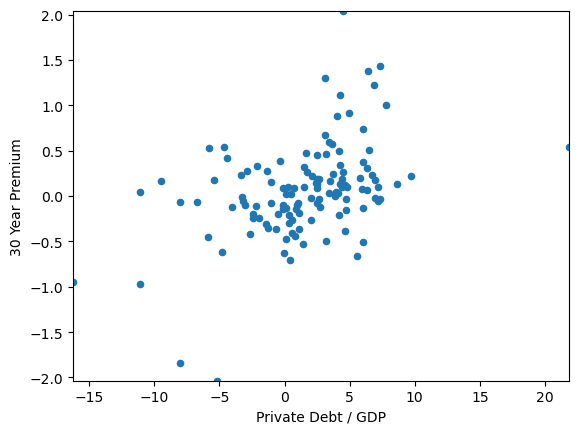

In [43]:
data["Private Debt / GDP"] = data["Private Debt"].div(data["Nominal GDP"]).mul(100)

data.resample("Q").mean().diff(4).plot.scatter(x = "Private Debt / GDP", y = "30 Year Premium")

C:\Users\JLCat\AppData\Local\Temp\ipykernel_40740\2040311243.py:4: UserWarning:

FixedFormatter should only be used together with FixedLocator



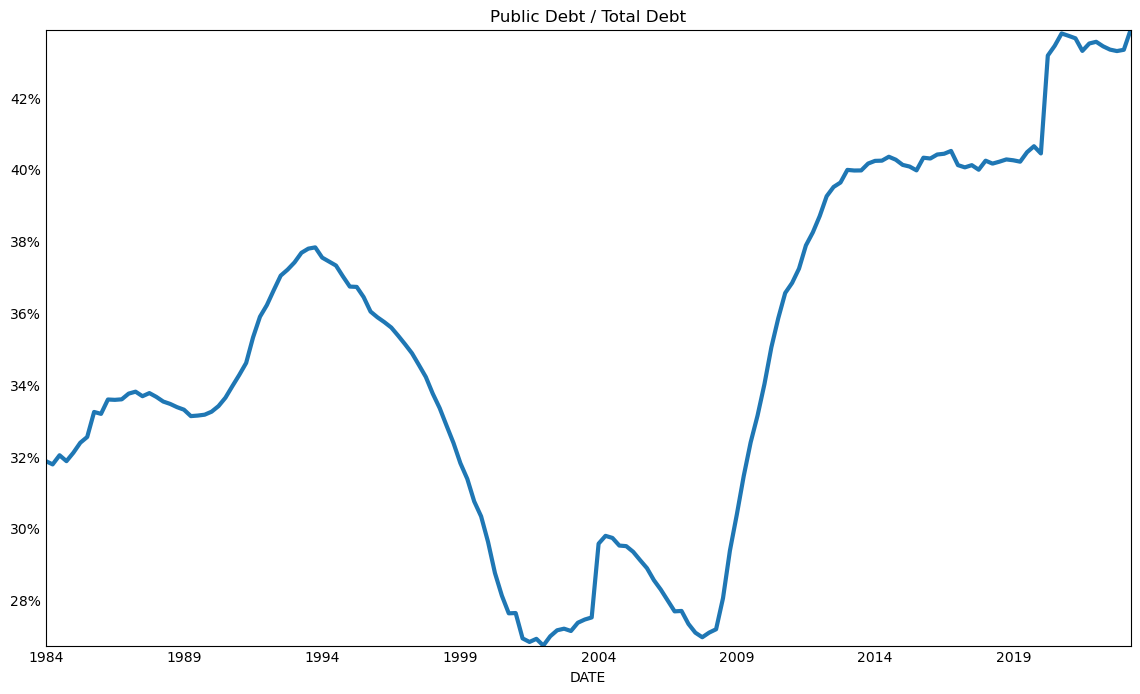

In [44]:
key = "Public Debt / Total Debt"
fig, ax = plt.subplots(figsize = (14,8))
data[key].resample("Q").mean().loc["1984":].plot(linewidth = 3, ax = ax)
ax.set_yticklabels(str(int(label)) + "%" for label in ax.get_yticks())
ax.set_title(key)
ax.tick_params(axis=u'both', which=u'both',length=0)

In [66]:
data

,Total Debt,Federal Debt,State and Local Debt,Commercial and Industrial Loans,"Total Loans, Excluding Federal Government",Nominal GDP,Real GDP,G,I,C,...,10 Year AAA Rate,30 Year AAA Rate,2 Years AAA Rate,5 Years AAA Rate,10 Years AAA Rate,30 Years AAA Rate,2 Year Premium,5 Year Premium,10 Year Premium,30 Year Premium
DATE,,,,,,,,,,,,,,,,,,,,,
1950-01-31,NaN,NaN,NaN,NaN,NaN,280828.0,2346.104,48.956,46.749,182.920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-30,NaN,NaN,NaN,NaN,NaN,290383.0,2417.682,49.643,52.291,186.806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,NaN,NaN,NaN,2807.055850,NaN,NaN,NaN,NaN,NaN,NaN,...,5.11,5.01,4.89,4.76,5.11,5.01,0.601429,0.995714,1.493810,1.141905
2023-01-31,70137443.0,27150204.0,3237190.0,2812.150950,35972573.0,26813601.0,22112.329,4643.890,4725.828,18269.569,...,4.93,4.92,4.81,4.61,4.93,4.92,0.602500,0.967000,1.398500,1.109500
2023-02-28,NaN,NaN,NaN,2809.967125,NaN,NaN,NaN,NaN,NaN,NaN,...,5.09,5.05,5.07,4.83,5.09,5.05,0.536316,0.887895,1.343158,1.103684


KeyError: 'AAA - FFR'

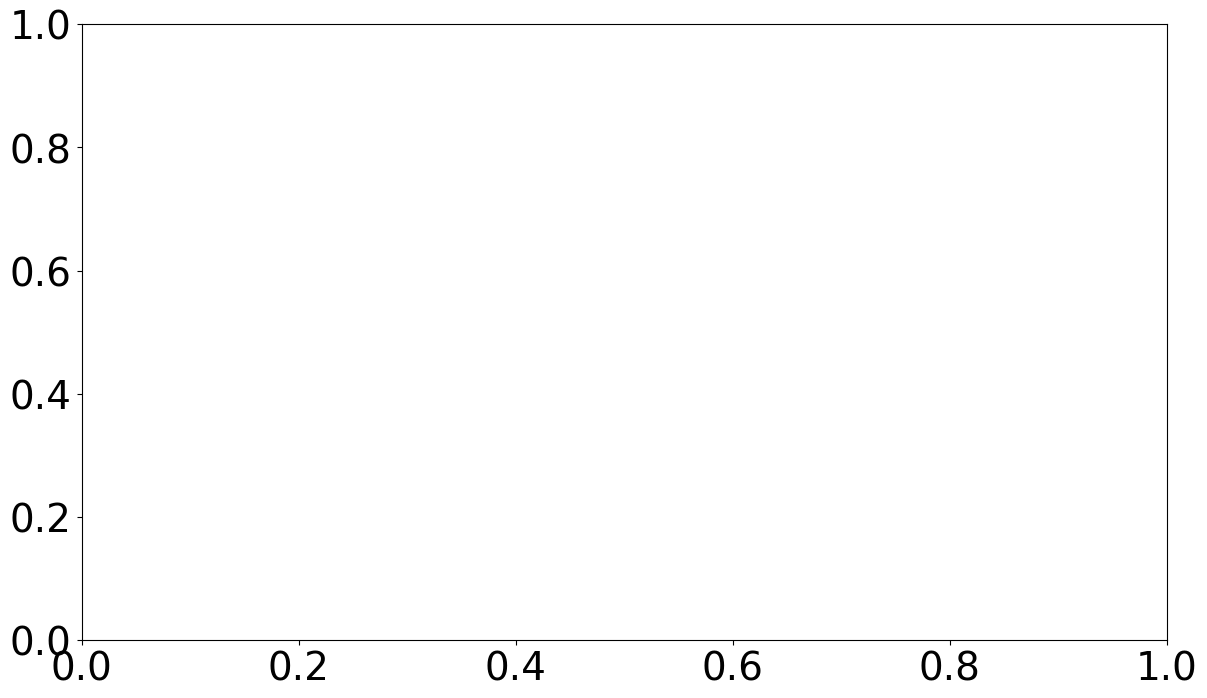

In [59]:
import pingouin
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})
plt.rcParams['axes.xmargin'] = 0  
plt.rcParams['axes.ymargin'] = 0
fig, ax = plt.subplots(figsize = (14,8))
plot_df = pct_change_df#.diff(4)#.diff(4)
key = "AAA - FFR"
plot_df[key] = rate_data[key]
max1 = plot_df[key].min() * -1
max2 = plot_df[key].max()
norm = plt.cm.colors.Normalize(max_c * -1, max_c)
max_c = max1 if max1 > max2 else max2
plot_df.plot.scatter(x="Private Debt",
                     y = "Real GDP",
                     c = key,
                     s = 100,
                     alpha = .9,
                     cmap = "coolwarm",
#                      norm = norm,
                     ax = ax)
ax.set_xlabel("Private Debt Growth %")
# plot_df1.plot.scatter(x="Aaa and Federal Funds Rate Spread",
#                      y ="Real GDP Growth %", 
#                      c = "Public Debt",
#                       alpha = .3,
#                       legend = False,
#                      ax = ax)

ax.axhline(0 , ls = "--", c= "k", alpha = .5)
ax.axvline(0 , ls = "--", c= "k", alpha = .5)

# ax.set_title("Year-over-Year Change")
# ax.set_xticklabels([str(int(val)) + "% " for val in ax.get_xticks()])
# ax.set_yticklabels([str(int(val)) + "% " for val in ax.get_yticks()])


KeyError: 'FFR'

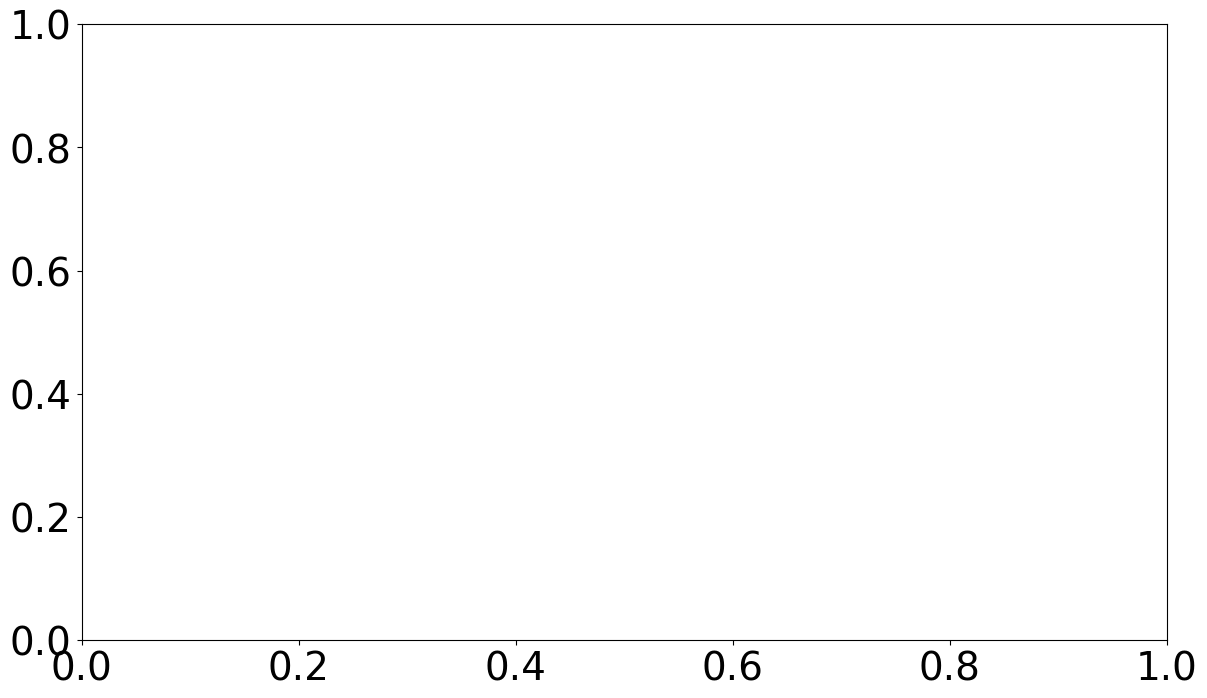

In [58]:
import pingouin
fig, ax = plt.subplots(figsize = (14,8))
plot_df = pct_change_df.diff(4)#.diff(4)
color_key = "Public Debt"
rename_color_key = color_key + " Growth %"
plot_df.rename(columns={color_key:rename_color_key}, inplace = True)
max1 = plot_df[rename_color_key].min() * -1
max2 = plot_df[rename_color_key].max()
max_c = max1 if max1 > max2 else max2

plot_df.plot.scatter(x="FFR",
                     y ="AAA - FFR", 
                     c = rename_color_key,
                     cmap = "coolwarm", 
                     norm = plt.cm.colors.Normalize(max_c * -1, max_c),
                     s = 100,
                     alpha = .9,
                     ax = ax)
# plot_df1.plot.scatter(x="Aaa and Federal Funds Rate Spread",
#                      y ="Real GDP Growth %", 
#                      c = "Public Debt",
#                       alpha = .3,
#                       legend = False,
#                      ax = ax)

ax.axhline(0 , ls = "--", c= "k", alpha = .5)
ax.axvline(0 , ls = "--", c= "k", alpha = .5)

ax.set_title("Year-over-Year Change")
# ax.set_xticklabels([str(int(val)) + "% " for val in ax.get_xticks()])
# ax.set_yticklabels([str(int(val)) + "% " for val in ax.get_yticks()])



KeyError: "['Private Debt / Total Debt'] not in index"

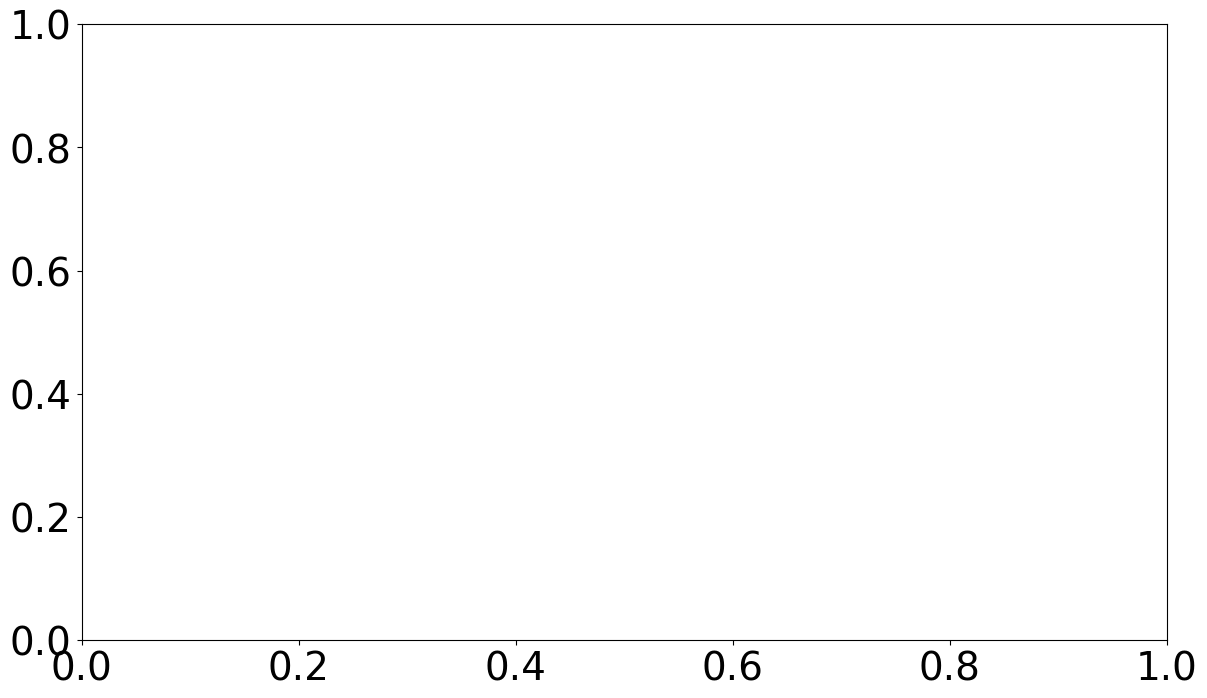

In [48]:
fig, ax = plt.subplots(figsize = (14, 8))
data[["Public Debt / Total Debt", "Private Debt / Total Debt"]].plot.area(ax = ax)

In [13]:
data[["Public Debt / Total Debt", "Private Debt / Total Debt"]].min()

NameError: name 'data' is not defined

In [ ]:
import pingouin
fig, ax = plt.subplots(figsize = (14,8))
plot_df = pct_change_df.diff(4)#.diff(4)
plot_df.plot.scatter(x="Public Debt / GDP",
                     y ="Real GDP Growth %", 
                     c = "Aaa and Federal Funds Rate Spread",
                     cmap = "viridis",
                     ax = ax)
ax.set_title("Change in Year-over-Year Change")
# ax.set_xticklabels([str(int(val)) + "% " for val in ax.get_xticks()])
# ax.set_yticklabels([str(int(val)) + "% " for val in ax.get_yticks()])
plot_df[["Aaa and Federal Funds Rate Spread",
         "Public Debt / Total Debt",
         "Real GDP"]].pcorr()

In [ ]:
import pingouin
import networkx as nx
from matplotlib.patches import ArrowStyle
from pgmpy.estimators import PC
from sklearn import linear_model

year = 4
def add_lags(data, lags=12 / year):
    for key in data:
        for i in range(1, lags + 1):
            new_key = key +" Lag" * i
            data[new_key] = var_data[key].shift(year * i)

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        self.predictor = self.predict(X) 
        # calculate matrix of same shape as y, use for ssr calculation
        mean_y = np.mean(y, axis = 0)
        mean_y = np.full((self.predictor.shape[0], self.predictor.shape[1]), mean_y)
        self.errors = y - self.predictor
        self.residuals = self.predictor - np.full((self.predictor.shape[0], self.predictor.shape[1]), mean_y)
        sse = np.sum(self.errors ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        ssr = np.sum((self.residuals) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        sst = sse + ssr 
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])])
        
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))        
        self.rsquared = ssr / sst
        print(self.rsquared)
        self.predictor = np.matmul(self.predictor, self.coef_)
        self.residuals = np.matmul(self.residuals, self.coef_)
        return self
def multivariate(endog, exog, sig_vals, constant = True):
    
    if constant:
        exog["Constant"] = 1
    endog_keys= list(endog.keys())
    exog_keys = list(exog.keys())
    reg = LinearRegression().fit(exog, endog)
    residuals = pd.DataFrame(reg.residuals).corr()
    res_keys = list(residuals.keys())
    residuals.rename(columns={res_keys[i]:endog_keys[i] for i in range(len(endog_keys))}, 
                     index = {res_keys[i]:endog_keys[i] for i in range(len(endog_keys))}, inplace = True)
    residuals = residuals.loc[endog_keys, endog_keys]
    print(residuals)
    results = {"coef_":{},
               "t":{}, 
               "p":{}}
    for key in results:
        for i in range(len(endog_keys)):
            endog = endog_keys[i]
            results[key][endog]={}
            for j in range(len(exog_keys)):
                exog = exog_keys[j]
                results[key][endog][exog_keys[j]] = getattr(reg,key)[i][j]
            
# pd.DataFrame([reg.coef_[0],reg.t[0], reg.p[0]], index= endog_keys, columns = exog_keys).T
    keys1 = list(results["coef_"].keys())
    for endog in keys1:
        keys2 = list(results["coef_"][endog].keys())
        for exog in keys2:
            label = ""
            pvalue = results["p"][endog][exog]
            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"
            results["coef_"][endog][exog] = str(round(results["coef_"][endog][exog],3)) + label 
        results["coef_"][endog]["r2"] = reg.rsquared[endog]

    return results["coef_"]#, results["p"]


def DAG_VAR(var_data, sink_source, filename, pp):
    reg_dict={}
    residuals = {}
    edges_weights = {}
    sig_vals = [.05, .01, .001]
    
    for sink, source in sink_source.items():
        variables = [sink] + source
        for k in range(len(variables)):
            key = variables[k]
            variables.append(key + " Lag")
            if key in sink_source.keys():
                if sink in sink_source[key] and sink not in variables:
                    variables.append(key)
        select_data = var_data[variables]
        select_data.dropna(inplace = True)
        endog_keys = [key for key in variables if "Lag" not in key]
        exog_keys = [key for key in variables if "Lag" in key]
        endog = select_data[endog_keys]
        exog = select_data[exog_keys]
        reg_dict[sink] = multivariate(endog, exog, sig_vals, constant = False)
        pd.DataFrame(reg_dict[sink])
        for sce in source:
#             print(sce, sink)
#             print(reg_dict[sink])#[sce+ " Lag"])
            edges_weights[(sce, sink)] = reg_dict[sink][sink][sce+ " Lag"]
    graph_DAG(edges = list(edges_weights.keys()), 
              df = select_data,
              edge_labels = edges_weights,
             pp = pp,
             title = "VAR Estimates\n"+diff.replace(" ", "") + "\n" + dates)
    for sink, dct in reg_dict.items():
        print(sink, pd.DataFrame(dct), "", sep = "\n")
        
        lag_keys = [key + " Lag" for key in dct] 
        if "Constant" in dct: lag_keys = lag_keys + ["Constant"]
        excel_df = pd.DataFrame(dct).T[lag_keys +["r2"]].T
        fname = sink + filename  
        excel_df.to_excel(fname.replace("/","").replace("\\","")+".xlsx")
        
def DAG(dag_data, variant, ci_test, sig):
    c = PC(dag_data)
#     edges = c.skeleton_to_pdag(*c.build_skeleton())
    max_cond_vars = len(dag_data.keys()) - 2
    model = c.estimate(return_type = "pdag",variant= variant, 
                       significance_level = sig, 
                       max_cond_vars = max_cond_vars, ci_test = ci_test)
    edges = model.edges()
    
    return edges

def graph_DAG(edges, df, pp, edge_labels = False, title = ""):
    def build_edge_labels(edges, df):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            sig_vals = [.05, .01, .001]
            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    graph = nx.DiGraph()
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, df) 
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = ax)
    
    plt.title(title, fontsize = 30)
#     print(edge_labels)
    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='C2')
    
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    pp.savefig(fig, bbox_inches = "tight")  
    plt.show()
    plt.close()
def identify_sink_nodes(edges):
    unzipped_edges = list(zip(*edges))
    source_nodes = unzipped_edges[0]
    sink_nodes = unzipped_edges[1]
#     sink_nodes = [node for node in sink_nodes if node not in source_nodes]
    caused_causal = {node:[] for node in sink_nodes}
    for source, sink in edges:
        caused_causal[sink].append(source)
    return caused_causal 


In [ ]:
variant = "parallel"
sig = .05
ci_test = "pearsonr"
pp = PdfPages("GDPAndPublicDebt.pdf")
plot_df = pct_change_df.diff(4)

plot_df = plot_df[["Public Debt / Total Debt","Real GDP","Aaa and Federal Funds Rate Spread"]].dropna()#.pcorr()
edges = DAG(plot_df, variant, ci_test, sig)
# add_lags(var_data, lags)
# sink_source = identify_sink_nodes(edges)
# filename ="PublicDebtAndGDP" 
# DAG_VAR(plot_df.dropna(), sink_source, filename, pp)

fig, ax = plt.subplots(figsize = (14,8))

plot_df.plot.scatter(x="Aaa and Federal Funds Rate Spread",
                     y ="Real GDP", 
                     c = "Public Debt / Total Debt",
                     cmap = "viridis",
                     ax = ax)
ax.set_title("Year-over-Year Change")
# ax.set_xticklabels([str(int(val)) + "% " for val in ax.get_xticks()])
# ax.set_yticklabels([str(int(val)) + "% " for val in ax.get_yticks()])


graph_DAG(edges, plot_df.rename(columns={key:key.replace(" ","\n")}),pp=pp)
plot_df.pcorr()

In [ ]:
plt.rcParams.update({'font.size': 28})
plt.rcParams['axes.xmargin'] = 0  
plt.rcParams['axes.ymargin'] = 0  
plot_df = data.copy()
plot_keys = ["Public Debt", "Private Debt"]
units_per_year = 4
ma_years = 10 
for key in plot_keys:
    plot_df[key] = plot_df[key].div(plot_df["Nominal GDP"])
plot_df["Real GDP"] = plot_df["Real GDP"].rolling(units_per_year * ma_years).mean()
fig, ax = plt.subplots(figsize = (14,8))
plot_df[plot_keys].plot.area(ax=ax, 
                             stacked=True, 
                             linewidth=0.).legend(loc = "lower left")
ax2 = ax.twinx()
plot_df.diff(units_per_year).loc["1960":,"Aaa and 10 Year Treasury Rate Spread"].plot.line(color = "C3",
                                                        ax = ax2, 
                                                        legend = False)
ax.set_yticklabels([str(round(val,2)) + "% " for val in ax.get_yticks()])
ax2.set_yticklabels([str(round(val, 2)) + "% " for val in ax2.get_yticks()])
plt.show()

In [ ]:
pct_change_df

In [ ]:
pct_change_diff_df

In [ ]:
import matplotlib.pyplot as plt
GDP_vars = ["G", "I", "C" ,"NX"]
df = data[GDP_vars]
fig, ax = plt.subplots(figsize = (14,8))
# split dataframe df into negative only and positive only values
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
# stacked area plot of positive values
df_pos.plot.area(ax=ax, stacked=True, linewidth=0., legend = True)
# reset the color cycle
ax.set_prop_cycle(None)
# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
# data["PY"].plot.line(ax = ax, ls = "--")


In [ ]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(2,1,figsize = (18,18))

pct_change_df[["G","I","Nominal Income"]].plot(ax = ax[0], legend = False)
ax[0].set_title("Growth Rate")
ax[0].set_yticklabels([str(int(round(val))) + "% " for val in ax[0].get_yticks()])

pct_change_diff_df[["G","I","PY"]].plot(ax = ax[1], legend = False)
ax[1].set_title("Change in Growth Rate")
ax[1].set_yticklabels([str(int(val)) + "% " for val in ax[1].get_yticks()])

In [ ]:
plt.rcParams.update({'font.size': 28})
data["C+I+NX"] = data["C"].add(data["I"]).add(data["NX"])
df = data.copy()
for key in ["G","C+I+NX"]:
    df[key] = df[key].div(df["Public Debt"])
fig, ax = plt.subplots(figsize = (14,8))
ax2 = ax.twinx()
df[["C+I+NX", "G"]].plot.area(ax=ax, stacked=True, linewidth=0., )
plot_df["Public Debt"] = plot_df["Public Debt"].rolling(units_per_year * ma_years).mean()

plot_df.pct_change(4).loc["1985":," GDP"].plot.line(color = "C3",
                                                        ax = ax2, 
                                                        legend = False)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()])


In [ ]:
keys = ["C", "I", "G", "PY"]# / GDP"]
                   
for x in keys:
    for y in keys:
        if x != y:
            for z in keys:
                if x != z and y != z:
                    fig, ax = plt.subplots(figsize = (14,8))
                    pct_change_diff_df.iloc[:].plot.scatter(x = x,y=y, c = z,# s = "NGDP",
                                                         cmap = "viridis",
                                                         ax = ax)


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = .01
plt.rcParams['axes.ymargin'] = .01  

Y_vars = ["PY","I"]
for y in Y_vars:
    x_vars= ["G"]
    y_var = [y]
    reg_df = pct_change_diff_df[x_vars+Y_vars].diff(4).dropna()
    Y = reg_df[y_var]
    X = reg_df[x_vars]
    X["Constant"] = 1
    
    model= sm.OLS(Y,X)
    results = model.fit()
    print(results.summary())
    reg_df[y + "-hat"] = results.predict()
    
    color_var = "PY" if y == "I" else "I"
    fig, ax = plt.subplots(figsize = (14,8))
    reg_df.plot.scatter(x = x_vars[0], 
                        y = y_var[0], 
                        c = color_var, 
                        cmap = "viridis", 
                        ax = ax)
    ax.plot(reg_df[x_vars[0]], reg_df[y_var[0]+ "-hat"],
            color = "k", 
            linewidth = 3,
           alpha = .7)
    ax.axhline(0, ls = "--", color = "k", alpha = .8)
    ax.axvline(0, ls = "--", color = "k", alpha = .8)
    x_vals = ax.get_xticks()
    ax.set_xticklabels([str(int(x))+"%" for x in x_vals])
    y_vals = ax.get_yticks()
    ax.set_yticklabels([str(int(y))+"%" for y in y_vals])
    plt.show()
    plt.close()

In [ ]:
plt.rcParams.update({'font.size': 28})
data[["Public Debt", "Private Debt", "Nominal GDP"]].plot(logy = True)

In [ ]:
data[["Private Debt / GDP", "Federal Debt / GDP", "Public Debt / GDP", "Federal Debt / Total Debt"]].plot()


In [ ]:
fig, ax = plt.subplots(figsize = (20,10))

ax2 = ax.twinx()
x = int(len(data) / 2)
NGDP_name =  "Real GDP % change"
debt_name = "Private Debt / Total Debt"
# plt.text(data.index[x],data.iloc[x][NGDP_name]/ 14.4,NGDP_name, fontsize = 28,ha = "center", color = "C0")
# plt.text(data.index[x],data.iloc[x][NGDP_name] / 10.2,debt_name, fontsize = 28,ha = "center", color = "C1")
# data["Real GDP % change"].dropna().plot.line(linewidth = 5,
#                                           ax = ax,
#                                           legend = False)
data["Private Debt / Total Debt"].dropna().plot.line(linewidth = 5,
                                           ax = ax2,
                                           legend = False,
                                           color = "C1")
ax.set_yticklabels([str(int(x)) + "%" for x in ax.get_yticks()])
ax2.set_yticklabels([str(int(x * 100)) + "%" for x in ax2.get_yticks()])
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
data.pct_change(4).plot.scatter(x = "Aaa Rate", 
                  y = "Federal Funds Rate", 
                  c = "Public Debt", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(x = "Private Debt / Total Debt diff", 
                  y = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Currency in Circulation / Total Assets diff", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(y = "Real GDP % change", 
                  x = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Private Debt / Public Debt diff", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")


In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(y = "Nominal GDP % change", 
                  x = "Private Debt / Public Debt diff",
                  c = "Real GDP % change", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")


In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(x = "Currency in Circulation / Total Assets diff", 
                  y = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Private Debt / Total Debt diff", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(x = "Federal Funds Rate diff", 
                  y = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Nominal GDP % change", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

In [ ]:
plot_scatter(data[["Private Debt / Public Debt diff",
                   "Aaa and Federal Funds Rate Spread",
                   "Nominal GDP % change"]], s = 500)

In [ ]:
data[["Nominal GDP % change", "Private Debt / Public Debt"]].corr()

In [ ]:
# set default fontsize for text in plot
plt.rcParams.update({'font.size': 24})
plt.rcParams['axes.ymargin'] = .05
plt.rcParams['axes.xmargin'] = .05

In [ ]:
import pingouin
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.patches import Rectangle
from pgmpy.estimators import PC
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df,  edge_labels = False, title = ""):
    def build_edge_labels(edges, df):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    print("keep control:", control)
                    keep_controls.append(control)                
            print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            sig_vals = [.05, .01, .001]
            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    graph = nx.DiGraph()
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, df) 
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
#     pp.savefig(fig, bbox_inches = "tight")  
    plt.show()
    plt.close()
    
def calculate_pcorr(data, keys):
    pcorr_df = data[keys]

    pcorr_dct = {}
    p_val_dct = {}
    for key1 in keys:
        p_val_dct[key1] = {}
        pcorr_dct[key1] = {}
        for key2 in keys:
            if key1 != key2:
                other_vars = [z for z in pcorr_df.keys() if z != key1 and z != key2 ]
                stats = pingouin.partial_corr(data=pcorr_df, 
                                              x = key1, 
                                              y = key2, 
                                              covars=other_vars)
                p_val_dct[key1][key2] = stats["p-val"].values[0]

                pcorr_dct[key1][key2] = pcorr_df.pcorr()[key1][key2]
            else:
                p_val_dct[key1][key2] = 1
                pcorr_dct[key1][key2] = 1

    p_val_df = pd.DataFrame(p_val_dct)
    pcorr_df = pd.DataFrame(pcorr_dct)
    return pcorr_df, p_val_df


In [ ]:
keys = ["C","I","G","PY"]
pcorr_df, p_val_df = calculate_pcorr(pct_change_diff_df, keys)
dag_df = pct_change_diff_df[keys]
dag_df = dag_df.dropna().rename(
    columns={
        col:col.replace(" ", "\n") for col in keys})
variant = "parallel"
sig = 0.2
ci_test = "pearsonr"
c = PC(dag_df)
max_cond_vars = len(keys) - 2
model = c.estimate(return_type = "dag",#variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)
edges = model.edges()
graph_DAG(edges, dag_df, edge_labels = False)  

In [ ]:
keys = ["Private Debt / Total Debt diff",
        "Nominal GDP % change",
        #"Nominal GDP % change year-over-year",
        "Aaa and Federal Funds Rate Spread diff",
#         "Federal Funds Rate diff year-over-year",
        "Currency in Circulation / Total Assets diff"]
pcorr_df, p_val_df = calculate_pcorr(data, keys)
dag_df = data[keys]
dag_df = dag_df.dropna().rename(
    columns={
        col:col.replace(" ", "\n") for col in keys})
variant = "parallel"
sig = 0.05
ci_test = "pearsonr"
c = PC(dag_df)
max_cond_vars = len(keys) - 2
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)
edges = model.edges()
graph_DAG(edges, dag_df)  